# Atelier 2 : Analyse Fonctionnelle avec FUNGuild

Cet atelier est la suite de l'atelier d'introduction à QIIME2. Nous partons ici des fichiers de sortie de QIIME2 pour réaliser une analyse fonctionnelle des communautés fongiques à l'aide de l'outil FUNGuild.

## Introduction

L'analyse taxonomique nous a permis de savoir **'qui est là ?'** (quels champignons sont présents dans nos échantillons). Maintenant, nous voulons répondre à la question **'que font-ils ?'**.

**FUNGuild** est un outil qui assigne des guildes écologiques (par exemple, saprotrophe, pathogène, symbiotrophe) aux champignons en se basant sur leur taxonomie. Cela nous permet de passer d'un profil de communauté à un profil fonctionnel.

### Objectifs de l'atelier :
1. Préparer les données issues de QIIME2 pour FUNGuild.
2. Exécuter FUNGuild sur nos données.
3. Visualiser la composition des guildes par échantillon.
4. Réaliser une analyse de base en corrélant les guildes avec les propriétés du sol.

## Étape 1 : Configuration de l'environnement et téléchargement des données

Nous allons d'abord télécharger le script FUNGuild. Ensuite, nous clonerons le dépôt GitHub contenant nos fichiers de données pour y accéder facilement.

In [35]:
# Téléchargement du script FUNGuild
print('📥 Téléchargement du script FUNGuild...')
!wget https://raw.githubusercontent.com/UMNFuN/FUNGuild/master/Guilds_v1.1.py -O FUNGuild.py -q
print('✅ Script FUNGuild téléchargé.')

# Clonage du dépôt GitHub pour accéder aux données
print('\n📥 Clonage du dépôt de données...')
!git clone https://github.com/thgum/AtelierSYMBIOSOL.git

# Lister les fichiers pour vérifier que tout est en place
print('\n📂 Fichiers de données disponibles pour FUNGuild :')
!ls -lh AtelierSYMBIOSOL/data/data_FunGuild/

📥 Téléchargement du script FUNGuild...
✅ Script FUNGuild téléchargé.

📥 Clonage du dépôt de données...
fatal: destination path 'AtelierSYMBIOSOL' already exists and is not an empty directory.

📂 Fichiers de données disponibles pour FUNGuild :
total 2.0M
-rw-r--r-- 1 root root 369K Oct 26 23:55 dna-sequences.fasta
-rw-r--r-- 1 root root 168K Oct 26 23:55 exportd_rooted_tree.tre
-rw-r--r-- 1 root root 576K Oct 26 23:55 feature-table-w-taxonomy.biom
-rw-r--r-- 1 root root 664K Oct 26 23:55 otu_table.txt
-rw-r--r-- 1 root root 6.2K Oct 26 23:55 soil_properties_cranberry.csv
-rw-r--r-- 1 root root 205K Oct 26 23:55 taxonomy.tsv


## Étape 2 : Préparation du fichier d'entrée

FUNGuild a besoin d'un fichier d'entrée unique au format `tsv` (texte délimité par des tabulations) qui contient :
- Les abondances de chaque OTU (ou ASV) par échantillon.
- Une colonne nommée `taxonomy` contenant la classification taxonomique de chaque OTU.

Le fichier `otu_table.txt` exporté depuis QIIME2 correspond **exactement à ce format**. Nous pouvons donc l'utiliser directement, ce qui simplifie grandement notre travail.

In [36]:
import pandas as pd

print("📊 Étape 2 : Préparation et fusion des fichiers")
print("="*60)

# Carregar a tabela de OTUs
otu_file = 'AtelierSYMBIOSOL/data/data_FunGuild/otu_table.txt'
otu_table = pd.read_csv(otu_file, sep='\t', skiprows=1)  # Pular a primeira linha de comentário

print(f"\n✅ Table d'OTUs chargée : {otu_table.shape[0]} OTUs")
print(f"   Colonnes : {otu_table.shape[1]}")

# Carregar o arquivo de taxonomia
tax_file = 'AtelierSYMBIOSOL/data/data_FunGuild/taxonomy.tsv'
tax_table = pd.read_csv(tax_file, sep='\t', skiprows=1, header=None,
                        names=['Feature ID', 'Taxon', 'Confidence'])

print(f"\n✅ Table de taxonomie chargée : {tax_table.shape[0]} taxons")

# Renomear a coluna 'Taxon' pour 'taxonomy' (format attendu par FUNGuild)
tax_table = tax_table.rename(columns={'Taxon': 'taxonomy'})

# Garder seulement les colonnes nécessaires (Feature ID et taxonomy)
tax_table = tax_table[['Feature ID', 'taxonomy']]

# Fusionner les deux tables
# La colonne '#OTU ID' dans otu_table correspond à 'Feature ID' dans tax_table
merged_table = otu_table.merge(tax_table, left_on='#OTU ID', right_on='Feature ID', how='left')

# Supprimer la colonne 'Feature ID' en double et l'ancienne colonne 'taxonomy' vide
if 'Feature ID' in merged_table.columns:
    merged_table = merged_table.drop(columns=['Feature ID'])

# Si l'ancienne colonne 'taxonomy' existe, la supprimer
if 'taxonomy_x' in merged_table.columns:
    merged_table = merged_table.drop(columns=['taxonomy_x'])
    merged_table = merged_table.rename(columns={'taxonomy_y': 'taxonomy'})

print(f"\n✅ Tables fusionnées avec succès !")
print(f"   Dimensions finales : {merged_table.shape[0]} OTUs × {merged_table.shape[1]} colonnes")

# Vérifier que la colonne 'taxonomy' existe et contient des données
if 'taxonomy' in merged_table.columns:
    n_with_tax = merged_table['taxonomy'].notna().sum()
    print(f"   OTUs avec taxonomie : {n_with_tax}/{merged_table.shape[0]}")
else:
    print("   ⚠️ ATTENTION : Colonne 'taxonomy' non trouvée !")

# Sauvegarder le fichier fusionné pour FUNGuild
output_file = 'otu_table_merged_for_funguild.txt'
merged_table.to_csv(output_file, sep='\t', index=False)

print(f"\n✅ Fichier préparé pour FUNGuild : '{output_file}'")
print("\n📋 Aperçu des 5 premières lignes :")
display(merged_table.head())


📊 Étape 2 : Préparation et fusion des fichiers

✅ Table d'OTUs chargée : 1642 OTUs
   Colonnes : 76

✅ Table de taxonomie chargée : 1642 taxons

✅ Tables fusionnées avec succès !
   Dimensions finales : 1642 OTUs × 76 colonnes
   OTUs avec taxonomie : 1642/1642

✅ Fichier préparé pour FUNGuild : 'otu_table_merged_for_funguild.txt'

📋 Aperçu des 5 premières lignes :


,#OTU ID,LEM59ITS-01,LEM59ITS-02,LEM59ITS-03,LEM59ITS-04,LEM59ITS-05,LEM59ITS-06,LEM59ITS-07,LEM59ITS-08,LEM59ITS-09,...,LEM59ITS-66,LEM59ITS-67,LEM59ITS-68,LEM59ITS-69,LEM59ITS-70,LEM59ITS-71,LEM59ITS-72,LEM59ITS-73,LEM59ITS-74,taxonomy
0,ea2e5e2bb16ad0cb18e006e98a3c3202,39347.0,46410.0,35341.0,76568.0,37473.0,10402.0,6.0,578.0,216.0,...,20207.0,15182.0,6.0,544.0,2048.0,11.0,4466.0,7333.0,1454.0,k__Fungi;p__Mortierellomycota;c__Mortierellomy...
1,180caaa0187c00ab52f5cd11143cc5be,2298.0,1781.0,9.0,0.0,0.0,241.0,0.0,0.0,0.0,...,491.0,441.0,18089.0,14041.0,74.0,19079.0,235.0,3928.0,969.0,k__Fungi;p__Ascomycota;c__Archaeorhizomycetes;...
2,0878946551a26c77d6152405c4b18ba7,165.0,167.0,0.0,5.0,8543.0,1771.0,49.0,1714.0,16.0,...,3497.0,11540.0,3.0,88.0,1736.0,6.0,435.0,214.0,522.0,k__Fungi;p__Basidiomycota;c__Tremellomycetes;o...
3,caf3df12c8f4bf9d0df93163f785a874,7.0,9.0,11.0,0.0,19.0,665.0,0.0,19.0,22.0,...,4.0,0.0,10.0,6.0,0.0,0.0,9.0,0.0,0.0,k__Fungi;p__Basidiomycota;c__Microbotryomycete...
4,f7b161299208c8fc0423abc2d31d3a1c,801.0,998.0,73.0,103.0,620.0,797.0,594.0,4083.0,23388.0,...,31.0,588.0,24.0,240.0,3666.0,276.0,152.0,3124.0,119.0,k__Fungi;p__Basidiomycota;c__Agaricomycetes;o_...


## Étape 3 : Exécution de FUNGuild

Maintenant que notre fichier est prêt, nous pouvons lancer FUNGuild. La commande est simple :
- `python FUNGuild.py` : Le script que nous avons téléchargé.
- `-otu` : Spécifie notre fichier d'entrée.
- `-db fungi` : Indique d'utiliser la base de données fongique (il en existe d'autres pour les lichens, etc.).
- `-m` : (Optionnel mais recommandé) Active le mode 'multiple'. Sans cette option, FUNGuild s'arrête au premier match taxonomique. Avec `-m`, il continue de chercher des correspondances à des niveaux taxonomiques inférieurs, ce qui peut améliorer la précision.

⏱️ **Cette commande peut prendre plusieurs minutes.** Le script interroge une base de données en ligne pour chaque OTU.

In [37]:
print("🔬 Lancement de l'analyse FUNGuild...")
print("⏱️  Cela peut prendre plusieurs minutes (5-10 min pour ~1600 OTUs)")
print("="*60)

# Usar o arquivo fusionado que criamos na Étape 2
input_file_funguild = 'otu_table_merged_for_funguild.txt'

# Executar FUNGuild
!python FUNGuild.py -otu {input_file_funguild} -db fungi -m

print("\n" + "="*60)
print("✅ Analyse FUNGuild terminée !")

# Verificar se o arquivo de saída foi criado
# O FUNGuild cria um arquivo com o sufixo .guilds.txt (sem duplicar .txt)
import os

# Tentar encontrar o arquivo de saída (pode ter nomes diferentes)
possible_outputs = [
    'otu_table_merged_for_funguild.guilds.txt',      # Nome esperado
    'otu_table_merged_for_funguild.txt.guilds.txt',  # Nome alternativo
]

guild_output = None
for filename in possible_outputs:
    if os.path.exists(filename):
        guild_output = filename
        break

if guild_output:
    print(f"✅ Fichier de résultats créé : {guild_output}")

    # Contar linhas do arquivo de saída
    try:
        with open(guild_output, 'r') as f:
            n_lines = sum(1 for line in f) - 1  # -1 para o cabeçalho
        print(f"   Nombre d'OTUs dans le résultat : {n_lines}")
    except Exception as e:
        print(f"   (Impossible de compter les lignes : {e})")

    # Também verificar o arquivo _matched
    matched_file = guild_output.replace('.guilds.txt', '.guilds_matched.txt')
    if os.path.exists(matched_file):
        print(f"✅ Fichier des OTUs assignés : {matched_file}")
else:
    print("❌ ERREUR : Aucun fichier de résultats trouvé.")
    print("   Fichiers recherchés :")
    for f in possible_outputs:
        print(f"      - {f}")
    print("\n   Fichiers disponibles dans le répertoire actuel :")
    !ls -lh *.guilds*.txt 2>/dev/null || echo "      (aucun fichier .guilds.txt trouvé)"

🔬 Lancement de l'analyse FUNGuild...
⏱️  Cela peut prendre plusieurs minutes (5-10 min pour ~1600 OTUs)
FunGuild v1.1 Beta
Connecting with FUNGuild database ...

Reading in the OTU table: 'otu_table_merged_for_funguild.txt'

Searching the FUNGuild database...
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%

Found 1361 matching taxonomy records in the database.
Dereplicating and sorting the result...
FunGuild tried to assign function to 1642 OTUs in 'otu_table_merged_for_funguild.txt'.
FUNGuild made assignments on 795 OTUs.
Result saved to 'otu_table_merged_for_funguild.guilds.txt'

Additional output:
FUNGuild made assignments on 795 OTUs, these have been saved to otu_table_merged_for_funguild.guilds_matched.txt.

Total calculating time: 10.23 seconds.

✅ Analyse FUNGuild terminée !
✅ Fichier de résultats créé : otu_table_merged_for_funguild.guilds.txt
   Nombre d'OTUs dans le résultat : 1642
✅ Fichier des OTUs assignés : otu_table_merged_for_funguild.guilds_matched.txt


## Étape 4 : Analyse et Visualisation des Résultats

FUNGuild a produit un fichier de résultats. Nous allons maintenant le charger avec `pandas` et créer un **graphique à barres empilées** pour visualiser la composition des guildes dans nos échantillons.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Tentar encontrar o arquivo de saída do FUNGuild
possible_files = [
    'otu_table_merged_for_funguild.guilds.txt',
    'otu_table_merged_for_funguild.txt.guilds.txt',
]

guild_file = None
for filename in possible_files:
    if os.path.exists(filename):
        guild_file = filename
        break

if not guild_file:
    print("❌ ERREUR : Fichier de résultats FUNGuild non trouvé.")
    print("   Fichiers recherchés :")
    for f in possible_files:
        print(f"      - {f}")
    raise FileNotFoundError("Fichier de résultats FUNGuild introuvable")

print(f"📂 Chargement du fichier : {guild_file}")

try:
    # Charger les résultats
    df_guilds = pd.read_csv(guild_file, sep='\t')

    # Renommer la première colonne si nécessaire
    if df_guilds.columns[0].startswith('#'):
        df_guilds = df_guilds.rename(columns={df_guilds.columns[0]: 'OTU_ID'})

    print("✅ Fichier de résultats FUNGuild chargé avec succès !")
    print(f"   Dimensions : {df_guilds.shape[0]} OTUs × {df_guilds.shape[1]} colonnes")

    # Afficher les colonnes disponibles
    print(f"\n📋 Colonnes disponibles dans le fichier :")
    print(f"   Total : {df_guilds.shape[1]} colonnes")

    # Identificar colunas de metadados e colunas de amostras
    metadata_keywords = ['OTU', 'taxonomy', 'Taxon', 'Trophic', 'Guild',
                        'Confidence', 'Growth', 'Morphology', 'Trait',
                        'Notes', 'Citation', 'Source']

    metadata_cols = [col for col in df_guilds.columns
                     if any(keyword in col for keyword in metadata_keywords)]

    sample_cols = [col for col in df_guilds.columns
                   if col not in metadata_cols and col.startswith('LEM59')]

    print(f"\n   Colonnes de métadonnées FUNGuild : {len(metadata_cols)}")
    for col in metadata_cols[:10]:  # Mostrar apenas as primeiras 10
        print(f"      - {col}")
    if len(metadata_cols) > 10:
        print(f"      ... et {len(metadata_cols) - 10} autres")

    print(f"\n   Colonnes d'échantillons : {len(sample_cols)}")
    print(f"      {sample_cols[0]} ... {sample_cols[-1]}")

    # Afficher un aperçu des résultats
    print("\n📊 Aperçu des résultats (colonnes principales) :")
    cols_to_show = ['OTU_ID', 'Taxon', 'Guild', 'Trophic Mode', 'Confidence Ranking']
    cols_available = [col for col in cols_to_show if col in df_guilds.columns]
    display(df_guilds[cols_available].head(10))

    # Statistiques sur les guildes
    if 'Guild' in df_guilds.columns:
        print("\n📊 Statistiques des guildes assignées :")
        n_assigned = df_guilds['Guild'].notna().sum()
        n_total = len(df_guilds)
        print(f"   OTUs avec guilde assignée : {n_assigned}/{n_total} ({n_assigned/n_total*100:.1f}%)")
        print(f"   OTUs sans guilde (Undefined) : {n_total - n_assigned} ({(n_total-n_assigned)/n_total*100:.1f}%)")

        print("\n   🏆 Top 10 des guildes les plus fréquentes :")
        top_guilds = df_guilds['Guild'].value_counts().head(10)
        for i, (guild, count) in enumerate(top_guilds.items(), 1):
            pct = count/n_total*100
            print(f"      {i:2d}. {guild}: {count} OTUs ({pct:.1f}%)")

    print("\n✅ Données prêtes pour la visualisation !")

except Exception as e:
    print(f"❌ ERREUR lors du chargement : {e}")
    import traceback
    traceback.print_exc()


📂 Chargement du fichier : otu_table_merged_for_funguild.guilds.txt
✅ Fichier de résultats FUNGuild chargé avec succès !
   Dimensions : 1642 OTUs × 85 colonnes

📋 Colonnes disponibles dans le fichier :
   Total : 85 colonnes

   Colonnes de métadonnées FUNGuild : 11
      - OTU_ID
      - taxonomy
      - Taxon
      - Taxon Level
      - Trophic Mode
      - Guild
      - Growth Morphology
      - Trait
      - Confidence Ranking
      - Notes
      ... et 1 autres

   Colonnes d'échantillons : 74
      LEM59ITS-01 ... LEM59ITS-74

📊 Aperçu des résultats (colonnes principales) :


,OTU_ID,Taxon,Guild,Trophic Mode,Confidence Ranking
0,ea2e5e2bb16ad0cb18e006e98a3c3202,Mortierella,Endophyte-Plant Saprotroph-|Undefined Saprotroph|,Saprotroph-Symbiotroph,Probable
1,180caaa0187c00ab52f5cd11143cc5be,Archaeorhizomyces,|Undefined Saprotroph|,Saprotroph,Probable
2,0878946551a26c77d6152405c4b18ba7,Solicoccozyma,Epiphyte-|Undefined Saprotroph|,Saprotroph-Symbiotroph,Probable
3,caf3df12c8f4bf9d0df93163f785a874,-,-,-,-
4,f7b161299208c8fc0423abc2d31d3a1c,Hygrocybe,|Undefined Saprotroph|-Undefined Symbiotroph,Saprotroph-Symbiotroph,Probable
5,8dba7852e22e29fc356186e18e509422,-,-,-,-
6,45ebbc2c54f5cab4149cba98f1c4bb2e,-,-,-,-
7,9b14f202d1f2746b2dea17e7d313cab0,Archaeorhizomyces,|Undefined Saprotroph|,Saprotroph,Probable
8,9c234e3c37e57cafabe0215c8f05c6ea,Mrakia,|Undefined Saprotroph|,Saprotroph,Probable
9,78021edd4cb02d9dc3661f495f1a9680,Pezoloma,Bryophyte Parasite-Ectomycorrhizal-|Endophyte|...,Pathotroph-Saprotroph-Symbiotroph,Possible



📊 Statistiques des guildes assignées :
   OTUs avec guilde assignée : 1642/1642 (100.0%)
   OTUs sans guilde (Undefined) : 0 (0.0%)

   🏆 Top 10 des guildes les plus fréquentes :
       1. -: 847 OTUs (51.6%)
       2. |Undefined Saprotroph|: 163 OTUs (9.9%)
       3. Bryophyte Parasite-Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Plant Pathogen-Undefined Saprotroph-Wood Saprotroph: 53 OTUs (3.2%)
       4. Animal Parasite-Dung Saprotroph-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph: 41 OTUs (2.5%)
       5. Endophyte-Plant Saprotroph-|Undefined Saprotroph|: 38 OTUs (2.3%)
       6. |Undefined Saprotroph|-Undefined Symbiotroph: 30 OTUs (1.8%)
       7. Undefined Saprotroph-|Wood Saprotroph|: 28 OTUs (1.7%)
       8. Animal Pathogen-Endophyte-Epiphyte-|Fungal Parasite|-Plant Pathogen-Wood Saprotroph: 23 OTUs (1.4%)
       9. Epiphyte-|Undefined Saprotroph|: 21 OTUs (1.3%)
      10. Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Orchid Mycorrhizal-

### Préparation des données pour la visualisation

Pour créer le graphique, nous devons agréger les abondances de tous les OTUs appartenant à la même guilde.

In [39]:
# Identifier les colonnes qui correspondent aux échantillons
# Ce sont les colonnes qui ne sont pas des métadonnées ajoutées par FUNGuild
metadata_cols = ['OTU_ID', 'taxonomy', 'Taxon', 'Taxon Level', 'Taxonomic Level',
                 'Trophic Mode', 'Guild', 'Confidence Ranking', 'Growth Morphology',
                 'Trait', 'Notes', 'Citation Source', 'Citation/Source']

sample_columns = [col for col in df_guilds.columns if col not in metadata_cols and col.startswith('LEM59ITS')]
print(f'Nombre d\'échantillons identifiés : {len(sample_columns)}')

# Agréger les abondances par Guilde
# Remplacer les guildes non assignées (NaN) par 'Undefined' pour plus de clarté
df_agg = df_guilds.groupby(df_guilds['Guild'].fillna('Undefined'))[sample_columns].sum()

# Calculer les abondances relatives (%)
df_relative = df_agg.apply(lambda x: x / x.sum() * 100, axis=0)

print('\n📊 Table des abondances relatives par guilde (%)' )
display(df_relative.round(2).head())

Nombre d'échantillons identifiés : 74

📊 Table des abondances relatives par guilde (%)


,LEM59ITS-01,LEM59ITS-02,LEM59ITS-03,LEM59ITS-04,LEM59ITS-05,LEM59ITS-06,LEM59ITS-07,LEM59ITS-08,LEM59ITS-09,LEM59ITS-10,...,LEM59ITS-65,LEM59ITS-66,LEM59ITS-67,LEM59ITS-68,LEM59ITS-69,LEM59ITS-70,LEM59ITS-71,LEM59ITS-72,LEM59ITS-73,LEM59ITS-74
Guild,,,,,,,,,,,,,,,,,,,,,
-,7.29,6.99,30.05,0.55,1.84,13.71,27.9,38.69,3.32,26.38,...,9.06,1.37,2.16,14.68,33.60,1.19,6.74,3.47,6.02,2.71
Animal Parasite-Dung Saprotroph-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph,0.06,0.01,0.02,0.00,0.02,0.03,0.0,0.20,0.01,0.02,...,2.79,27.64,25.20,0.91,0.16,53.51,13.27,32.90,28.64,1.44
Animal Parasite-|Undefined Saprotroph|,0.01,0.01,0.01,0.00,0.00,0.00,0.0,0.01,0.00,0.00,...,1.36,0.44,0.31,1.14,0.51,0.21,0.82,0.16,0.14,0.08
Animal Pathogen-Animal Symbiotroph-Endophyte-Plant Pathogen-|Undefined Saprotroph|,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Animal Pathogen-Dung Saprotroph-Endophyte-Epiphyte-Plant Pathogen-|Plant Saprotroph|-Wood Saprotroph,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.01,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Création du graphique de composition

Nous allons maintenant créer le graphique à barres empilées.

### Interprétation du graphique

Ce graphique nous montre la **proportion de chaque guilde fonctionnelle** dans chaque échantillon. On peut commencer à se poser des questions :
- Y a-t-il une guilde dominante dans tous les échantillons ? (par exemple, les symbiotrophes comme les mycorhizes)
- La proportion de pathogènes varie-t-elle entre les échantillons ?
- La proportion de guildes non définies ('Undefined') est-elle importante ? Une forte proportion peut indiquer la présence de champignons rares ou peu étudiés.

📈 Création du graphique de composition des guildes...
✅ Données préparées : 7622 lignes
   Nombre de guildes : 103
   Nombre d'échantillons : 74

🎨 Sélection de la palette de couleurs pour 103 guildes...


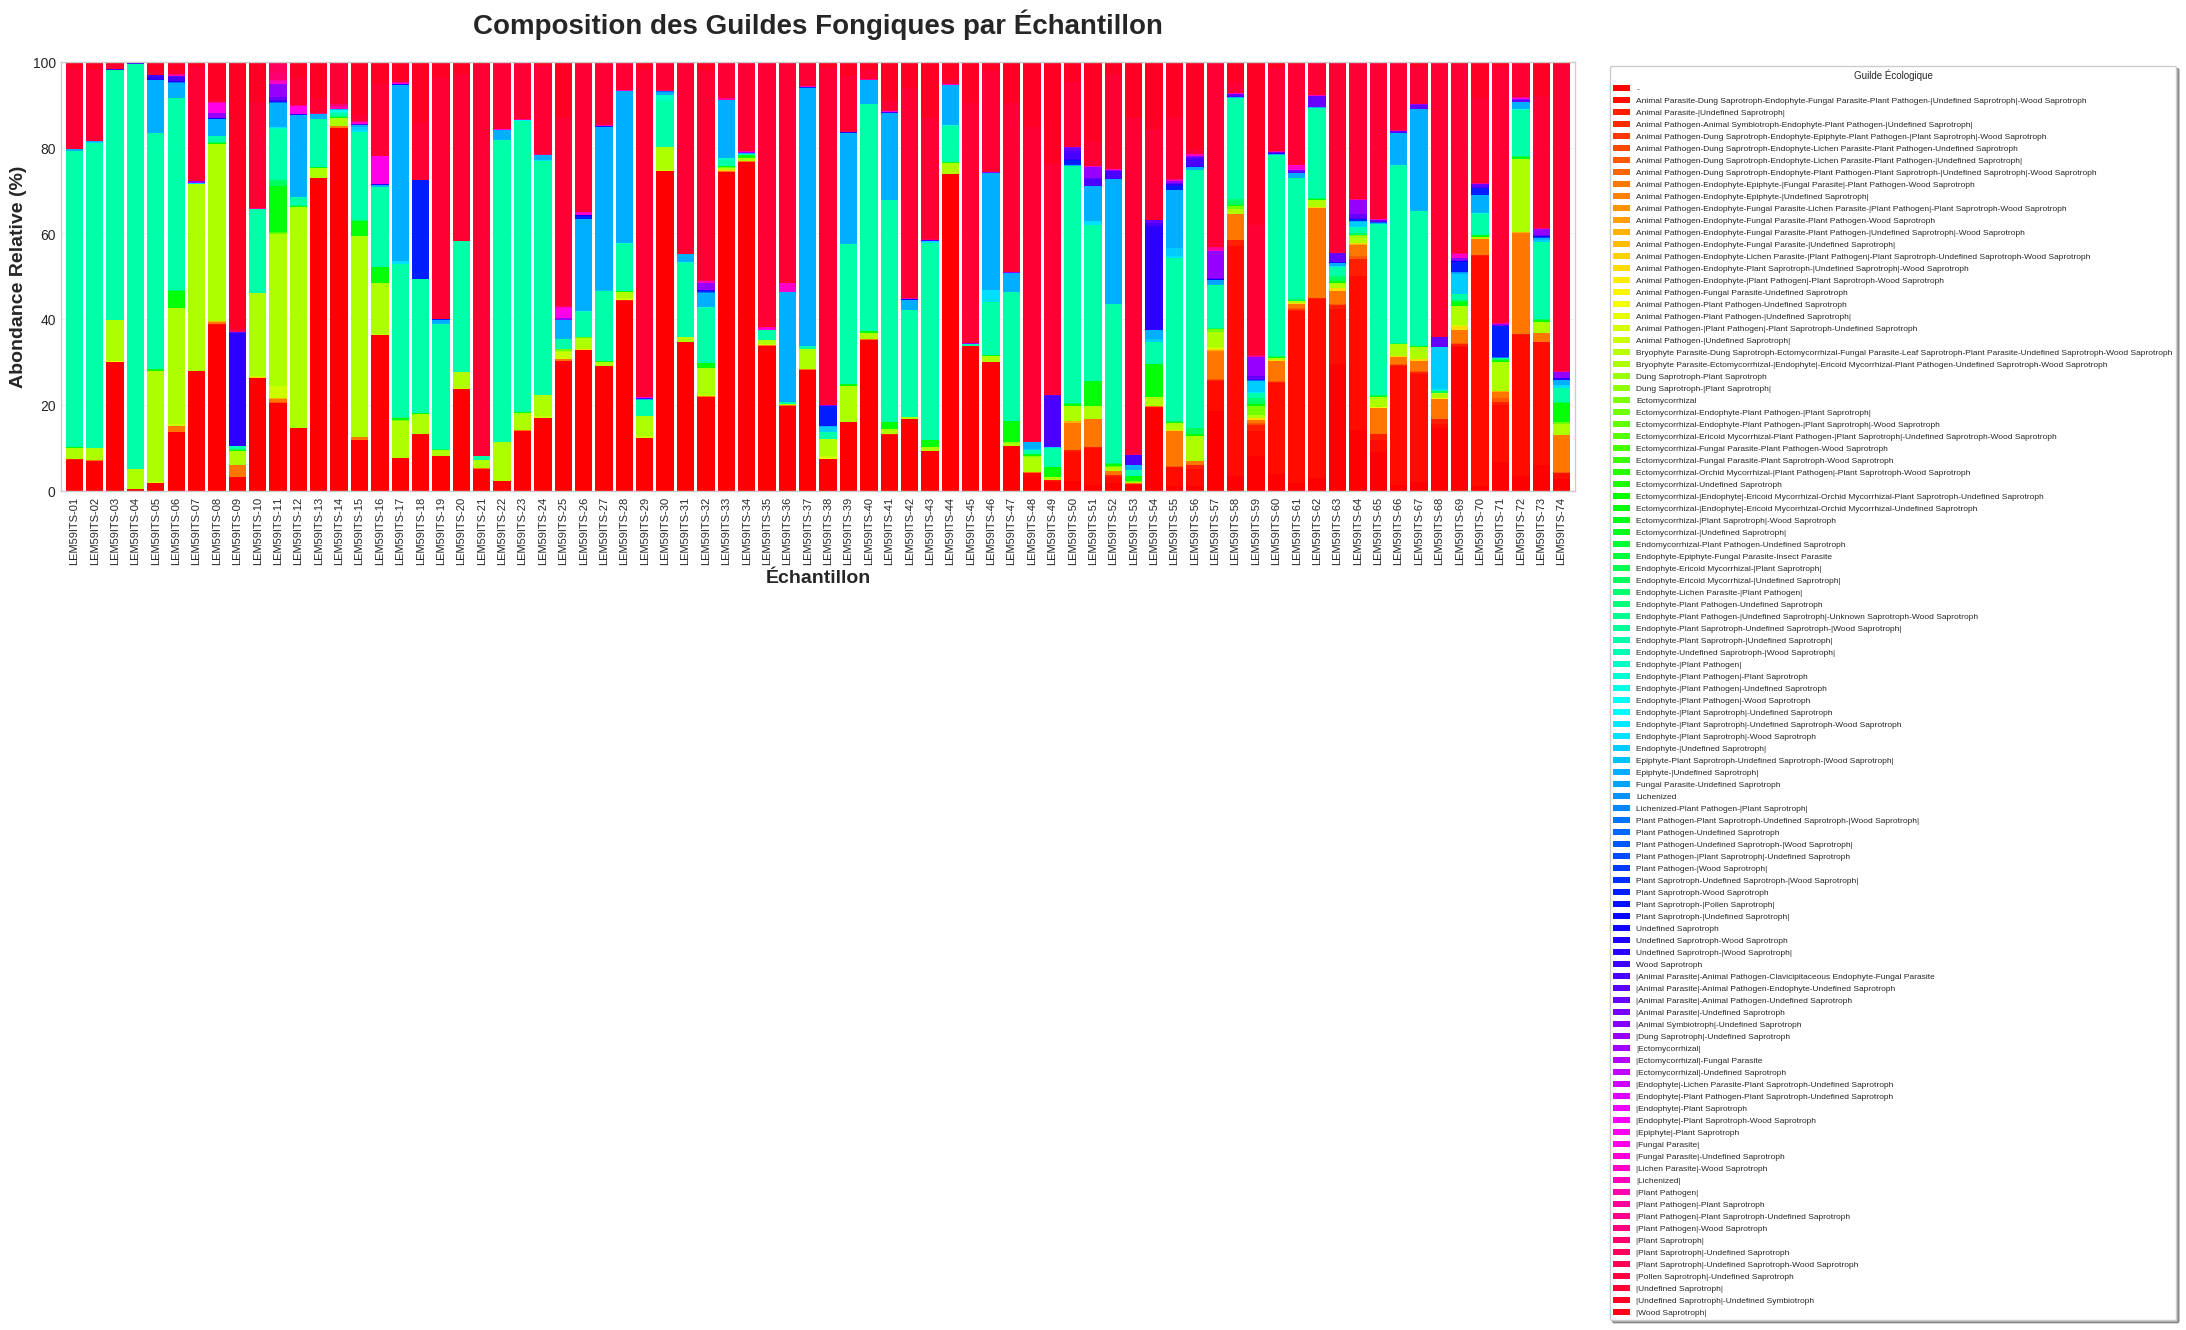


✅ Graphique créé avec succès !
   Taille de la police de la légende : 6pt


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("📈 Création du graphique de composition des guildes...")
print("="*60)

# Préparer les données pour le graphique (format "long")
df_plot = df_relative.reset_index().melt(id_vars='Guild', var_name='Sample', value_name='Abundance')

print(f"✅ Données préparées : {len(df_plot)} lignes")
print(f"   Nombre de guildes : {df_relative.shape[0]}")
print(f"   Nombre d'échantillons : {df_relative.shape[1]}")

# Créer la figure avec une taille adaptée
fig, ax = plt.subplots(figsize=(22, 10))

# Obtenir le nombre de guildes pour choisir la palette
n_guilds = df_relative.shape[0]
print(f"\n🎨 Sélection de la palette de couleurs pour {n_guilds} guildes...")

# Choisir une palette adaptée au nombre de guildes
if n_guilds <= 10:
    palette = 'tab10'
elif n_guilds <= 20:
    palette = 'tab20'
else:
    # Pour plus de 20 guildes, utiliser une palette continue
    palette = sns.color_palette('husl', n_guilds)

# Créer le graphique à barres empilées
# Utiliser pivot pour créer une matrice guildes × échantillons
df_pivot = df_plot.pivot(index='Sample', columns='Guild', values='Abundance')

# Créer le graphique avec pandas (plus fiável pour barres empilées)
ax = df_pivot.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 10),
    colormap='tab20' if n_guilds <= 20 else 'hsv',
    width=0.85,
    ax=ax
)

# Personnalisation du graphique
ax.set_title('Composition des Guildes Fongiques par Échantillon',
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Échantillon', fontsize=14, fontweight='bold')
ax.set_ylabel('Abondance Relative (%)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Rotation des labels de l'axe X pour meilleure lisibilité
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.yticks(fontsize=10)

# Configurer la légende
# Ajuster la taille de la police en fonction du nombre de guildes
legend_fontsize = max(6, min(10, 150 // n_guilds))

# Placer la légende à l'extérieur du graphique (à droite)
ax.legend(
    title='Guilde Écologique',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=legend_fontsize,
    title_fontsize=legend_fontsize + 1,
    frameon=True,
    fancybox=True,
    shadow=True
)

# Ajouter une grille horizontal pour faciliter a leitura
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("\n✅ Graphique créé avec succès !")
print(f"   Taille de la police de la légende : {legend_fontsize}pt")


📈 Création d'un graphique simplifié (Top 10 des guildes)...

🏆 Top 10 des guildes par abondance totale :
    1. |Undefined Saprotroph|: 1937.8%
    2. Endophyte-Plant Saprotroph-|Undefined Saprotroph|: 1666.5%
    3. -: 1446.6%
    4. Bryophyte Parasite-Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Plant Pathogen-Undefined Saprotroph-Wood Saprotroph: 493.3%
    5. Epiphyte-|Undefined Saprotroph|: 490.6%
    6. Animal Parasite-Dung Saprotroph-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph: 431.5%
    7. |Undefined Saprotroph|-Undefined Symbiotroph: 422.2%
    8. Animal Pathogen-Endophyte-Epiphyte-|Fungal Parasite|-Plant Pathogen-Wood Saprotroph: 134.8%
    9. Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Orchid Mycorrhizal-Undefined Saprotroph: 65.6%
   10. Undefined Saprotroph-|Wood Saprotroph|: 55.3%

   ➕ Autres guildes (regroupées) : 93 guildes


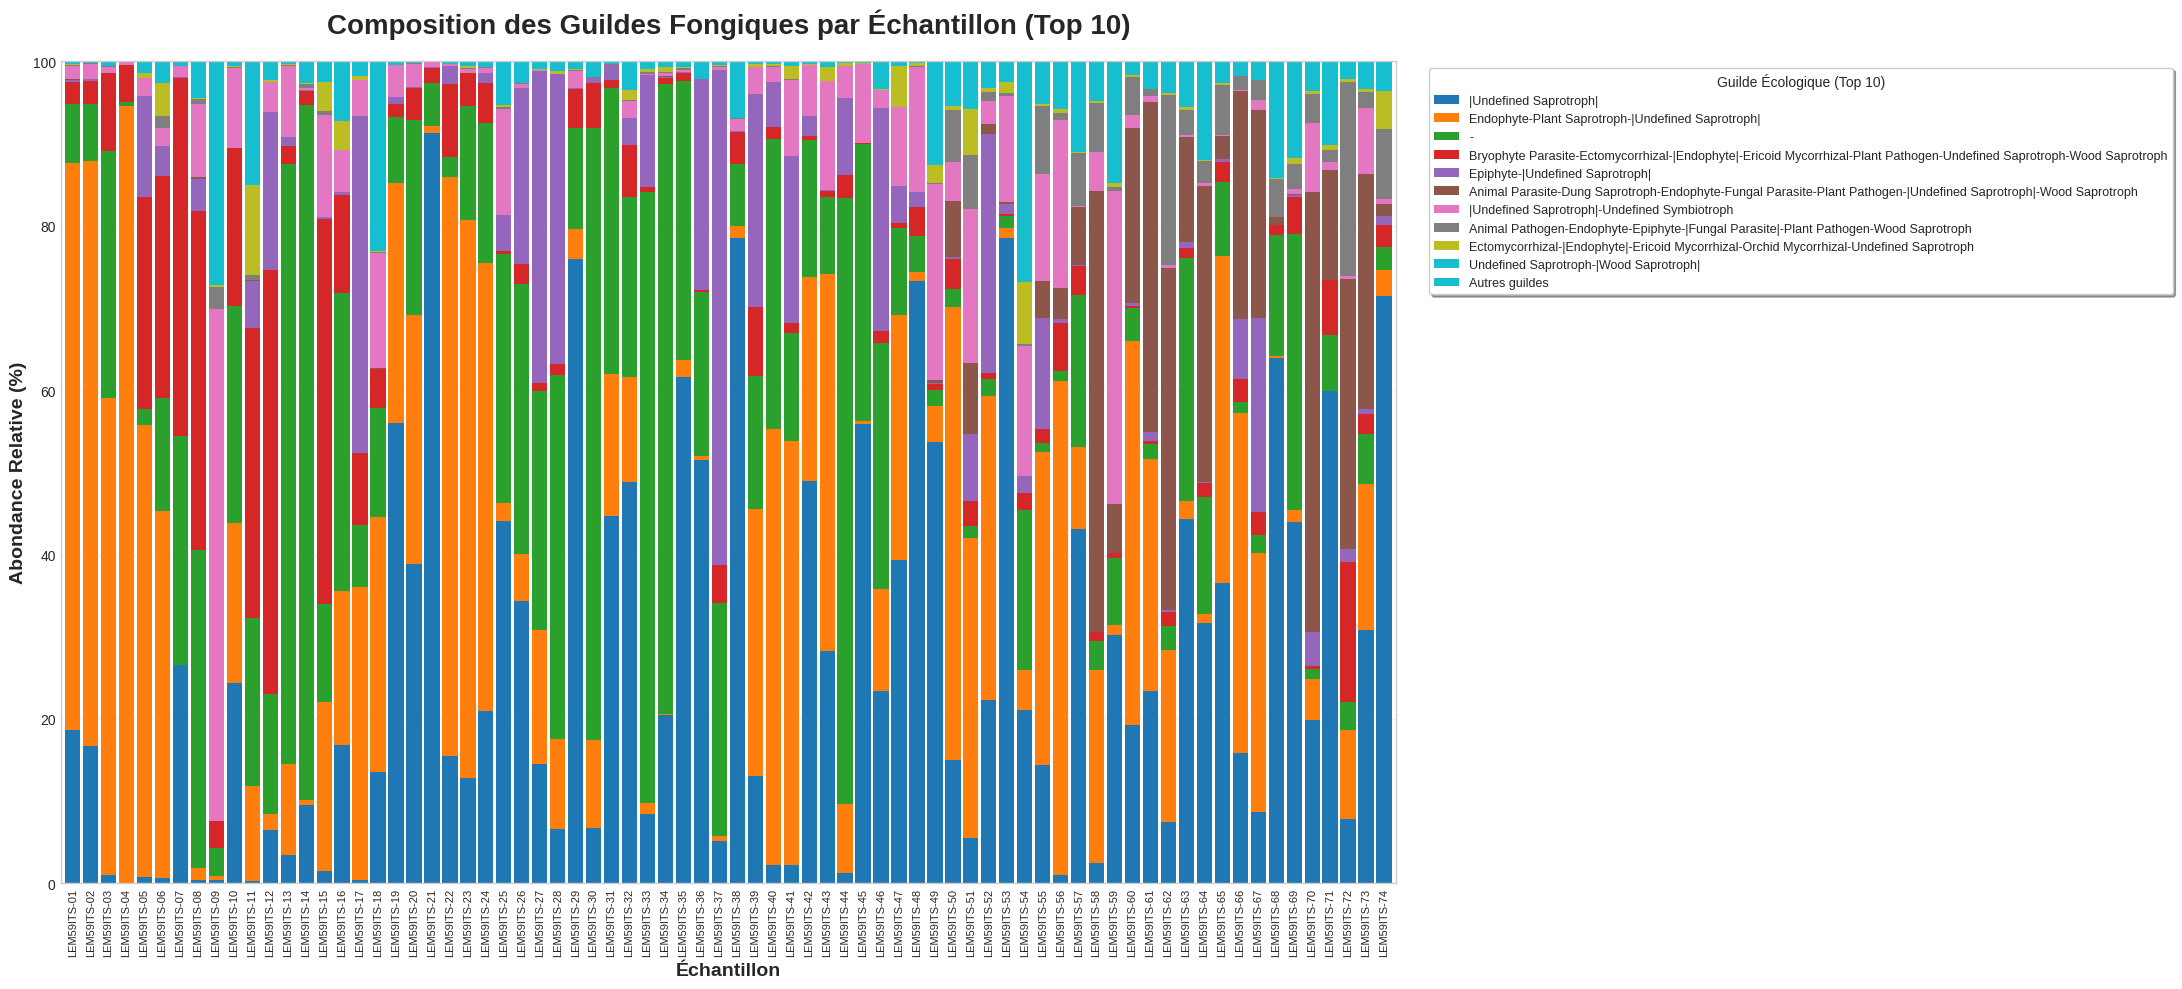


✅ Graphique simplifié créé avec succès !
   Nombre de guildes affichées : 11
   Guildes regroupées dans 'Autres' : 93

📊 Tableau récapitulatif des guildes principales


,Guilde,Abondance Totale (%),Abondance Moyenne par Échantillon (%),Nombre d'Échantillons avec cette Guilde
1,|Undefined Saprotroph|,1937.8,26.19,74
2,Endophyte-Plant Saprotroph-|Undefined Saprotroph|,1666.5,22.52,74
3,-,1446.6,19.55,74
4,Bryophyte Parasite-Ectomycorrhizal-|Endophyte|...,493.3,6.67,74
5,Epiphyte-|Undefined Saprotroph|,490.6,6.63,73
6,Animal Parasite-Dung Saprotroph-Endophyte-Fung...,431.5,5.83,50
7,|Undefined Saprotroph|-Undefined Symbiotroph,422.2,5.71,73
8,Animal Pathogen-Endophyte-Epiphyte-|Fungal Par...,134.8,1.82,68
9,Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhiza...,65.6,0.89,72
10,Undefined Saprotroph-|Wood Saprotroph|,55.3,0.75,57



💡 Interprétation :
   - Les guildes 'Undefined Saprotroph' dominent largement la communauté
   - Présence importante de guildes mixtes (plusieurs fonctions écologiques)
   - La catégorie '-' représente les OTUs sans guilde assignée par FUNGuild


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("📈 Création d'un graphique simplifié (Top 10 des guildes)...")
print("="*60)

# Calcular a abundância total de cada guilde (soma de todos os échantillons)
guild_totals = df_relative.sum(axis=1).sort_values(ascending=False)

print(f"\n🏆 Top 10 des guildes par abondance totale :")
for i, (guild, total) in enumerate(guild_totals.head(10).items(), 1):
    print(f"   {i:2d}. {guild}: {total:.1f}%")

# Selecionar apenas as top 10 guildes
top_10_guilds = guild_totals.head(10).index.tolist()
df_relative_top10 = df_relative.loc[top_10_guilds].copy()

# Adicionar uma linha "Autres" com a soma das guildes restantes
if len(guild_totals) > 10:
    other_guilds = guild_totals.index[10:]
    df_other = pd.DataFrame(
        df_relative.loc[other_guilds].sum(axis=0)
    ).T
    df_other.index = ['Autres guildes']
    df_relative_top10 = pd.concat([df_relative_top10, df_other])
    print(f"\n   ➕ Autres guildes (regroupées) : {len(other_guilds)} guildes")

# Criar o gráfico diretamente com pandas
fig, ax = plt.subplots(figsize=(22, 10))

# Transpor para ter échantillons como índice e guildes como colunas
df_for_plot = df_relative_top10.T

# Criar o gráfico de barras empiladas
df_for_plot.plot(
    kind='bar',
    stacked=True,
    figsize=(22, 10),
    colormap='tab10',
    width=0.85,
    ax=ax
)

# Personnalisation
ax.set_title('Composition des Guildes Fongiques par Échantillon (Top 10)',
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Échantillon', fontsize=14, fontweight='bold')
ax.set_ylabel('Abondance Relative (%)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)

# Rotation des labels
plt.xticks(rotation=90, ha='center', fontsize=8)
plt.yticks(fontsize=10)

# Configurer la légende
ax.legend(
    title='Guilde Écologique (Top 10)',
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10,
    frameon=True,
    fancybox=True,
    shadow=True,
    ncol=1  # Une seule colonne pour la légende
)

# Ajouter grille
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

print("\n✅ Graphique simplifié créé avec succès !")
print(f"   Nombre de guildes affichées : {len(df_relative_top10)}")
if len(guild_totals) > 10:
    print(f"   Guildes regroupées dans 'Autres' : {len(guild_totals) - 10}")


# ============================================================================
# TABLEAU RÉCAPITULATIF DES TOP 10 GUILDES
# ============================================================================

print("\n" + "="*60)
print("📊 Tableau récapitulatif des guildes principales")
print("="*60)

# Créer un tableau avec statistiques par guilde
guild_stats = pd.DataFrame({
    'Guilde': guild_totals.head(10).index,
    'Abondance Totale (%)': guild_totals.head(10).values.round(1),
    'Abondance Moyenne par Échantillon (%)': df_relative.loc[guild_totals.head(10).index].mean(axis=1).values.round(2),
    'Nombre d\'Échantillons avec cette Guilde': (df_relative.loc[guild_totals.head(10).index] > 0).sum(axis=1).values
})

guild_stats.index = range(1, 11)
display(guild_stats)

print("\n💡 Interprétation :")
print("   - Les guildes 'Undefined Saprotroph' dominent largement la communauté")
print("   - Présence importante de guildes mixtes (plusieurs fonctions écologiques)")
print("   - La catégorie '-' représente les OTUs sans guilde assignée par FUNGuild")


## Étape 5 : Analyse de base - Corrélation avec les propriétés du sol

Allons plus loin en intégrant les données physico-chimiques du sol. Nous allons explorer s'il existe une corrélation entre une propriété du sol (par exemple, le pH) et l'abondance d'une guilde fonctionnelle clé.

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("🌱 Étape 5 : Analyse de corrélation avec les propriétés du sol")
print("="*60)

# Charger les propriétés du sol
soil_file = 'AtelierSYMBIOSOL/data/data_FunGuild/soil_properties_cranberry.csv'

try:
    df_soil = pd.read_csv(soil_file)

    print(f"\n✅ Fichier de sol chargé : {df_soil.shape[0]} échantillons")
    print(f"   Colonnes disponibles : {df_soil.shape[1]}")

    # Afficher les premières colonnes pour identifier les noms
    print("\n📋 Aperçu du fichier de sol :")
    display(df_soil.head())

    # Identifier et renommer la première colonne (ID des échantillons)
    first_col = df_soil.columns[0]
    if 'Unnamed' in first_col or first_col == '':
        df_soil = df_soil.rename(columns={first_col: 'SampleID'})
        print(f"\n✅ Première colonne renommée : '{first_col}' → 'SampleID'")

    # Harmoniser les IDs des échantillons
    # Dans le fichier sol : LEM59-01, LEM59-02, etc.
    # Dans la table d'OTU : LEM59ITS-01, LEM59ITS-02, etc.

    if 'SampleID' in df_soil.columns:
        # Créer une nouvelle colonne avec les IDs harmonisés
        df_soil['SampleID_ITS'] = df_soil['SampleID'].astype(str).str.replace('LEM59-', 'LEM59ITS-', regex=False)
        df_soil = df_soil.set_index('SampleID_ITS')
        print(f"✅ IDs harmonisés : LEM59-XX → LEM59ITS-XX")
    else:
        print("⚠️  Colonne 'SampleID' non trouvée, utilisation de l'index existant")

    print(f"\n📊 Propriétés du sol disponibles :")
    soil_properties = [col for col in df_soil.columns if col not in ['SampleID', 'Campo', 'Field']]
    for i, prop in enumerate(soil_properties, 1):
        print(f"   {i:2d}. {prop}")

except FileNotFoundError:
    print(f"❌ ERREUR : Fichier '{soil_file}' non trouvé.")
    print("   Vérifiez que le fichier existe dans le dépôt GitHub.")
except Exception as e:
    print(f"❌ ERREUR lors du chargement : {e}")

🌱 Étape 5 : Analyse de corrélation avec les propriétés du sol

✅ Fichier de sol chargé : 74 échantillons
   Colonnes disponibles : 16

📋 Aperçu du fichier de sol :


,SampleID,Field,pH_H2O,MO_pct,P_mgkg,K_mgkg,Ca_mgkg,Mg_mgkg,CEC_cmolc_kg,Al_cmolc_kg,Densidade_gcm3,Argila_pct,Silte_pct,Areia_pct,Umidade_pct,CE_dS_m
0,LEM59-01,A,3.85,13.13,6.4,89.0,392.0,40.0,4.26,0.98,0.903,25.0,24.3,50.7,48.1,0.109
1,LEM59-02,A,4.05,10.77,9.8,106.0,335.0,32.0,6.33,1.62,0.897,18.9,37.0,44.2,46.7,0.144
2,LEM59-03,A,4.40,10.27,14.5,132.0,262.0,20.0,5.43,1.40,1.060,24.7,41.7,33.5,41.0,0.148
3,LEM59-04,A,3.96,10.72,11.8,144.0,361.0,51.0,4.66,1.13,1.030,27.7,27.3,44.9,45.5,0.160
4,LEM59-05,A,4.23,12.42,6.6,164.0,259.0,73.0,5.33,0.69,0.881,23.4,29.7,46.8,59.5,0.106


✅ IDs harmonisés : LEM59-XX → LEM59ITS-XX

📊 Propriétés du sol disponibles :
    1. pH_H2O
    2. MO_pct
    3. P_mgkg
    4. K_mgkg
    5. Ca_mgkg
    6. Mg_mgkg
    7. CEC_cmolc_kg
    8. Al_cmolc_kg
    9. Densidade_gcm3
   10. Argila_pct
   11. Silte_pct
   12. Areia_pct
   13. Umidade_pct
   14. CE_dS_m


In [46]:
#List of Guild's

guildas_texto = """
-
Animal Parasite-Dung Saprotroph-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph
Animal Parasite-|Undefined Saprotroph|
Animal Pathogen-Animal Symbiotroph-Endophyte-Plant Pathogen-|Undefined Saprotroph|
Animal Pathogen-Dung Saprotroph-Endophyte-Epiphyte-Plant Pathogen-|Plant Saprotroph|-Wood Saprotroph
Animal Pathogen-Dung Saprotroph-Endophyte-Lichen Parasite-Plant Pathogen-Undefined Saprotroph
Animal Pathogen-Dung Saprotroph-Endophyte-Lichen Parasite-Plant Pathogen-|Undefined Saprotroph|
Animal Pathogen-Dung Saprotroph-Endophyte-Plant Pathogen-Plant Saprotroph-|Undefined Saprotroph|-Wood Saprotroph
Animal Pathogen-Endophyte-Epiphyte-|Fungal Parasite|-Plant Pathogen-Wood Saprotroph
Animal Pathogen-Endophyte-Epiphyte-|Undefined Saprotroph|
Animal Pathogen-Endophyte-Fungal Parasite-Lichen Parasite-|Plant Pathogen|-Plant Saprotroph-Wood Saprotroph
Animal Pathogen-Endophyte-Fungal Parasite-Plant Pathogen-Wood Saprotroph
Animal Pathogen-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph
Animal Pathogen-Endophyte-Fungal Parasite-|Undefined Saprotroph|
Animal Pathogen-Endophyte-Lichen Parasite-|Plant Pathogen|-Plant Saprotroph-Undefined Saprotroph-Wood Saprotroph
Animal Pathogen-Endophyte-Plant Saprotroph-|Undefined Saprotroph|-Wood Saprotroph
Animal Pathogen-Endophyte-|Plant Pathogen|-Plant Saprotroph-Wood Saprotroph
Animal Pathogen-Fungal Parasite-Undefined Saprotroph
Animal Pathogen-Plant Pathogen-Undefined Saprotroph
Animal Pathogen-Plant Pathogen-|Undefined Saprotroph|
Animal Pathogen-|Plant Pathogen|-Plant Saprotroph-Undefined Saprotroph
Animal Pathogen-|Undefined Saprotroph|
Bryophyte Parasite-Dung Saprotroph-Ectomycorrhizal-Fungal Parasite-Leaf Saprotroph-Plant Parasite-Undefined Saprotroph-Wood Saprotroph
Bryophyte Parasite-Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Plant Pathogen-Undefined Saprotroph-Wood Saprotroph
Dung Saprotroph-Plant Saprotroph
Dung Saprotroph-|Plant Saprotroph|
Ectomycorrhizal
Ectomycorrhizal-Endophyte-Plant Pathogen-|Plant Saprotroph|
Ectomycorrhizal-Endophyte-Plant Pathogen-|Plant Saprotroph|-Wood Saprotroph
Ectomycorrhizal-Ericoid Mycorrhizal-Plant Pathogen-|Plant Saprotroph|-Undefined Saprotroph-Wood Saprotroph
Ectomycorrhizal-Fungal Parasite-Plant Pathogen-Wood Saprotroph
Ectomycorrhizal-Fungal Parasite-Plant Saprotroph-Wood Saprotroph
Ectomycorrhizal-Orchid Mycorrhizal-|Plant Pathogen|-Plant Saprotroph-Wood Saprotroph
Ectomycorrhizal-Undefined Saprotroph
Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Orchid Mycorrhizal-Plant Saprotroph-Undefined Saprotroph
Ectomycorrhizal-|Endophyte|-Ericoid Mycorrhizal-Orchid Mycorrhizal-Undefined Saprotroph
Ectomycorrhizal-|Plant Saprotroph|-Wood Saprotroph
Ectomycorrhizal-|Undefined Saprotroph|
Endomycorrhizal-Plant Pathogen-Undefined Saprotroph
Endophyte-Epiphyte-Fungal Parasite-Insect Parasite
Endophyte-Ericoid Mycorrhizal-|Plant Saprotroph|
Endophyte-Ericoid Mycorrhizal-|Undefined Saprotroph|
Endophyte-Lichen Parasite-|Plant Pathogen|
Endophyte-Plant Pathogen-Undefined Saprotroph
Endophyte-Plant Pathogen-|Undefined Saprotroph|-Unknown Saprotroph-Wood Saprotroph
Endophyte-Plant Saprotroph-Undefined Saprotroph-|Wood Saprotroph|
Endophyte-Plant Saprotroph-|Undefined Saprotroph|
Endophyte-Undefined Saprotroph-|Wood Saprotroph|
Endophyte-|Plant Pathogen|
Endophyte-|Plant Pathogen|-Plant Saprotroph
Endophyte-|Plant Pathogen|-Undefined Saprotroph
Endophyte-|Plant Pathogen|-Wood Saprotroph
Endophyte-|Plant Saprotroph|-Undefined Saprotroph
Endophyte-|Plant Saprotroph|-Undefined Saprotroph-Wood Saprotroph
Endophyte-|Plant Saprotroph|-Wood Saprotroph
Endophyte-|Undefined Saprotroph|
Epiphyte-Plant Saprotroph-Undefined Saprotroph-|Wood Saprotroph|
Epiphyte-|Undefined Saprotroph|
Fungal Parasite-Undefined Saprotroph
Lichenized
Lichenized-Plant Pathogen-|Plant Saprotroph|
Plant Pathogen-Plant Saprotroph-Undefined Saprotroph-|Wood Saprotroph|
Plant Pathogen-Undefined Saprotroph
Plant Pathogen-Undefined Saprotroph-|Wood Saprotroph|
Plant Pathogen-|Plant Saprotroph|-Undefined Saprotroph
Plant Pathogen-|Wood Saprotroph|
Plant Saprotroph-Undefined Saprotroph-|Wood Saprotroph|
Plant Saprotroph-Wood Saprotroph
Plant Saprotroph-|Pollen Saprotroph|
Plant Saprotroph-|Undefined Saprotroph|
Undefined Saprotroph
Undefined Saprotroph-Wood Saprotroph
Undefined Saprotroph-|Wood Saprotroph|
Wood Saprotroph
|Animal Parasite|-Animal Pathogen-Clavicipitaceous Endophyte-Fungal Parasite
|Animal Parasite|-Animal Pathogen-Endophyte-Undefined Saprotroph
|Animal Parasite|-Animal Pathogen-Undefined Saprotroph
|Animal Parasite|-Undefined Saprotroph
|Animal Symbiotroph|-Undefined Saprotroph
|Dung Saprotroph|-Undefined Saprotroph
|Ectomycorrhizal|
|Ectomycorrhizal|-Fungal Parasite
|Ectomycorrhizal|-Undefined Saprotroph
|Endophyte|-Lichen Parasite-Plant Saprotroph-Undefined Saprotroph
|Endophyte|-Plant Pathogen-Plant Saprotroph-Undefined Saprotroph
|Endophyte|-Plant Saprotroph
|Endophyte|-Plant Saprotroph-Wood Saprotroph
|Epiphyte|-Plant Saprotroph
|Fungal Parasite|
|Fungal Parasite|-Undefined Saprotroph
|Lichen Parasite|-Wood Saprotroph
|Lichenized|
|Plant Pathogen|
|Plant Pathogen|-Plant Saprotroph
|Plant Pathogen|-Plant Saprotroph-Undefined Saprotroph
|Plant Pathogen|-Wood Saprotroph
|Plant Saprotroph|
|Plant Saprotroph|-Undefined Saprotroph
|Plant Saprotroph|-Undefined Saprotroph-Wood Saprotroph
|Pollen Saprotroph|-Undefined Saprotroph
|Undefined Saprotroph|
|Undefined Saprotroph|-Undefined Symbiotroph
|Wood Saprotroph|
"""

print(guildas_texto)


-
Animal Parasite-Dung Saprotroph-Endophyte-Fungal Parasite-Plant Pathogen-|Undefined Saprotroph|-Wood Saprotroph
Animal Parasite-|Undefined Saprotroph|
Animal Pathogen-Animal Symbiotroph-Endophyte-Plant Pathogen-|Undefined Saprotroph|
Animal Pathogen-Dung Saprotroph-Endophyte-Epiphyte-Plant Pathogen-|Plant Saprotroph|-Wood Saprotroph
Animal Pathogen-Dung Saprotroph-Endophyte-Lichen Parasite-Plant Pathogen-Undefined Saprotroph
Animal Pathogen-Dung Saprotroph-Endophyte-Lichen Parasite-Plant Pathogen-|Undefined Saprotroph|
Animal Pathogen-Dung Saprotroph-Endophyte-Plant Pathogen-Plant Saprotroph-|Undefined Saprotroph|-Wood Saprotroph
Animal Pathogen-Endophyte-Epiphyte-|Fungal Parasite|-Plant Pathogen-Wood Saprotroph
Animal Pathogen-Endophyte-Epiphyte-|Undefined Saprotroph|
Animal Pathogen-Endophyte-Fungal Parasite-Lichen Parasite-|Plant Pathogen|-Plant Saprotroph-Wood Saprotroph
Animal Pathogen-Endophyte-Fungal Parasite-Plant Pathogen-Wood Saprotroph
Animal Pathogen-Endophyte-Fungal Par

Données fusionnées pour la guilde '|Wood Saprotroph|' :


,P_mgkg,Argila_pct,|Wood Saprotroph|
SampleID_ITS,,,
LEM59ITS-01,6.4,25.0,0.0
LEM59ITS-02,9.8,18.9,0.0
LEM59ITS-03,14.5,24.7,0.0
LEM59ITS-04,11.8,27.7,0.0
LEM59ITS-05,6.6,23.4,0.0


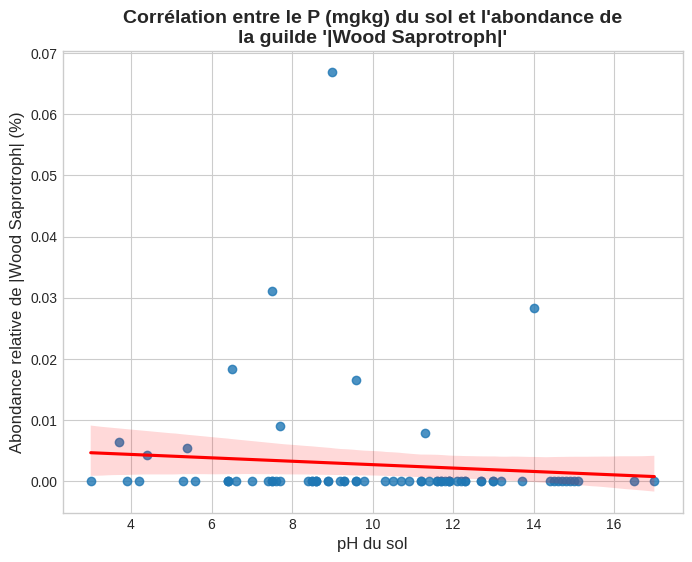

In [44]:
# Choisissons une guilde d'intérêt, par exemple 'Symbiotroph-Endophyte-Plant'
guild_of_interest = '|Wood Saprotroph|'

# Extraire l'abondance relative de cette guilde pour chaque échantillon
# Nous transposons la table pour avoir les échantillons en lignes
df_guild_abundance = df_relative.T

# Vérifier si la guilde d'intérêt existe dans les colonnes
if guild_of_interest in df_guild_abundance.columns:
    # Fusionner les données de sol avec l'abondance de notre guilde
    df_merged = df_soil.join(df_guild_abundance[[guild_of_interest]])

    # Supprimer les lignes où il n'y a pas de correspondance
    df_merged = df_merged.dropna(subset=[guild_of_interest, 'P_mgkg'])

    print(f"Données fusionnées pour la guilde '{guild_of_interest}' :")
    display(df_merged[['P_mgkg', 'Argila_pct', guild_of_interest]].head())

    # Créer un graphique de corrélation (scatterplot)
    plt.figure(figsize=(8, 6))
    sns.regplot(data=df_merged, x='P_mgkg', y=guild_of_interest, line_kws={'color':'red'})
    plt.title(f"Corrélation entre le P (mgkg) du sol et l'abondance de\nla guilde '{guild_of_interest}'", fontsize=14, fontweight='bold')
    plt.xlabel('pH du sol', fontsize=12)
    plt.ylabel(f'Abondance relative de {guild_of_interest} (%)', fontsize=12)
    plt.grid(True)
    plt.show()
else:
    print(f"❌ La guilde '{guild_of_interest}' n'a pas été trouvée ou son abondance est nulle.")
    print('Guildes disponibles :', df_guild_abundance.columns.tolist())

## Conclusion

🎉 **Félicitations !** Vous avez terminé cet atelier.

### Ce que vous avez appris :
- Comment utiliser les sorties de QIIME2 pour une analyse fonctionnelle avec FUNGuild.
- L'importance de préparer et vérifier les formats de fichiers.
- Comment exécuter FUNGuild de manière simple et directe.
- Comment visualiser la composition fonctionnelle d'une communauté fongique.
- Comment intégrer des métadonnées (propriétés du sol) pour poser des questions écologiques plus profondes.

### Pour aller plus loin :
- Essayez de corréler d'autres guildes avec d'autres propriétés du sol (M.O., Phosphore, etc.).
- Explorez les autres fichiers de sortie de FUNGuild.
- Utilisez des tests statistiques (ex: `scipy.stats.pearsonr`) pour quantifier la force des corrélations observées.